In [29]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

import pandas as pd

import torch
from torch.utils.data import DataLoader
from preprocessing import *
from experimental_neural_nets import Road_data, UNet
from road_correction import process_roads, f1_loss_numpy

In [30]:
# Global params for UNet and Road Correction (SEARCH or LOAD, option to SAVE if SEARCH)
UNET_SEARCH = False
SAVE_UNET = False
ROAD_CORRECTION_SEARCH = False
SAVE_RC_PARAMS = False
UNET_MODEL_LOAD = 'UNet_model.pth'
UNET_MODEL_SAVE = 'UNet_model.pth'
RC_LOAD = 'RC_params.pth'
RC_SAVE = 'RC_params.pth'

In [31]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [32]:
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files))  # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#imgs,gt_imgs = rotate_train_data(imgs,gt_imgs)
#imgs,gt_imgs = flip_train_data(imgs,gt_imgs)

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


In [ ]:
# Search for best parameters of the model (base_C and num_layers) or load from save
if UNET_SEARCH:

    # Modulate search
    num_epochs = 5
    batch_size = 10
    bases = [4,8,16]
    layers = np.arange(3,6)

    dataset = Road_data(imgs,gt_imgs)

    best_loss = np.inf
    best_base = 0
    best_n_layer = 0


    for base_c in bases:
        for n_layer in layers:

            model = UNet(base_c=base_c,num_layers=n_layer)
            losses = []
            criterion = torch.nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            for epoch in range(num_epochs):
                for batch_idx, (data, target) in enumerate(dataloader):

                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                losses.append(loss)
                scheduler.step()
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
                
            c_loss = min(losses)
            if c_loss < best_loss:
                best_base = base_c
                best_n_layer = n_layer
                best_loss = c_loss

print (best_base, best_n_layer)

In [34]:
# training of best model or loading from save
if UNET_SEARCH:

    # Modulate training
    num_epochs = 10
    batch_size = 10

    dataset = Road_data(imgs,gt_imgs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNet(base_c=best_base,num_layers=best_n_layer)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(dataloader):

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
    
    # optional save
    if SAVE_UNET:
        torch.save(model, UNET_MODEL_SAVE)
        
else:
    model = torch.load(UNET_MODEL_LOAD)

model.eval()

/var/folders/7_/thb0nb1n68j5t838_czz_hh00000gn/T/ipykernel_34293/3206420760.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(UNET_MODEL_LOAD)


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU(inplace=True)
    )
  )
  (downs): ModuleList(
    (0): Down(
      (down): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padd

In [35]:
# search of best params for road correction after model prediction or load them from 

if ROAD_CORRECTION_SEARCH:

    # Modulate search
    outlier_sizes = np.arange(10, 100, 10)
    shape_sizes = np.arange(3, 10)

    dataset = Road_data(imgs, gt_imgs)
    dataloader = DataLoader(dataset, batch_size=20, shuffle=True)

    threshold = 0.5
    best_outlier_size = 0
    best_shape_size = 0
    best_loss = np.inf

    for outlier_size in outlier_sizes:
        for shape_size in shape_sizes:

            print(f'outlier size : {outlier_size} | shape size : {shape_size}')
            c_losses = []
            
            for batch_idx, (data, target) in enumerate(dataloader):

                gt = target
                images = data
                pred = model(data)

                gt_np = gt.detach().cpu().numpy()
                pred_np = pred.detach().cpu().numpy()
                test_pred = np.array([
                    process_roads(raw_map=raw_map, threshold=threshold, outlier_size=outlier_size, shape_size=shape_size) 
                    for raw_map in pred_np
                    ])
                
                c_losses.append(np.mean([f1_loss_numpy(p, truth) for p, truth in zip(test_pred,gt_np)]))
            
            c_loss = np.mean(c_losses)
            if c_loss < best_loss:
                best_loss = c_loss
                best_outlier_size = outlier_size
                best_shape_size = shape_size

    # optional save
    if SAVE_RC_PARAMS:
        best_params = {'best_outlier_size':best_outlier_size,'best_shape_size':best_shape_size}
        torch.save(best_params, RC_SAVE)

else:
    best_params = torch.load(RC_LOAD)
    best_outlier_size = best_params['best_outlier_size']
    best_shape_size = best_params['best_shape_size']


/var/folders/7_/thb0nb1n68j5t838_czz_hh00000gn/T/ipykernel_34293/2157217571.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_params = torch.load(RC_LOAD)


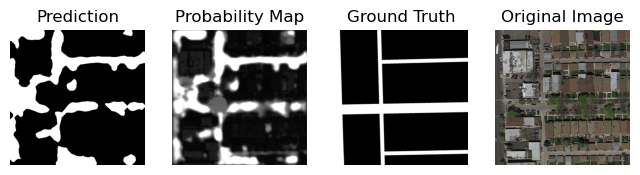

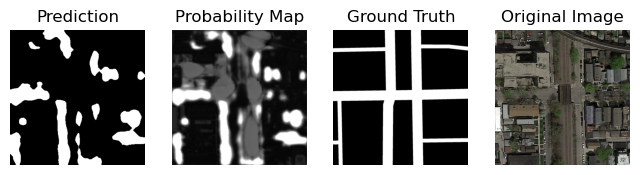

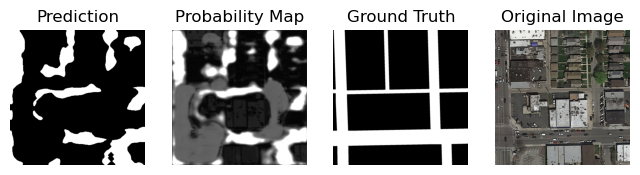

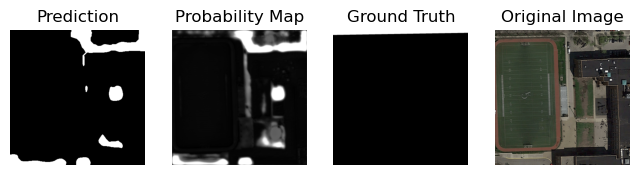

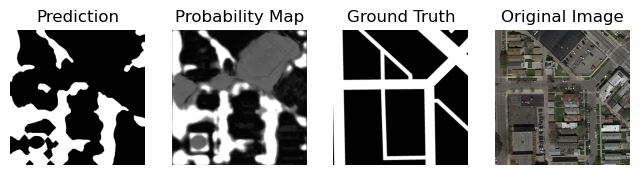

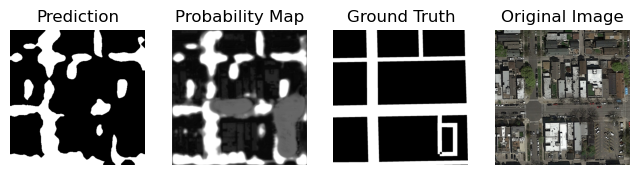

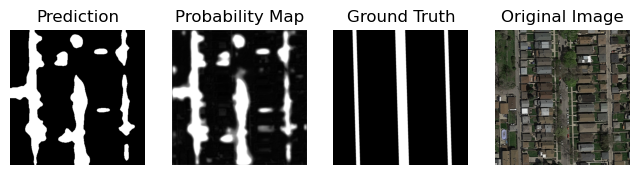

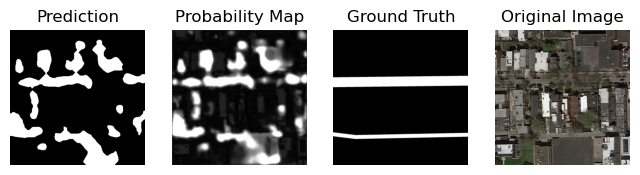

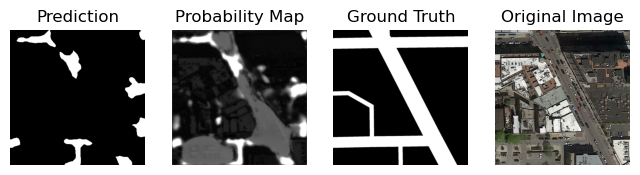

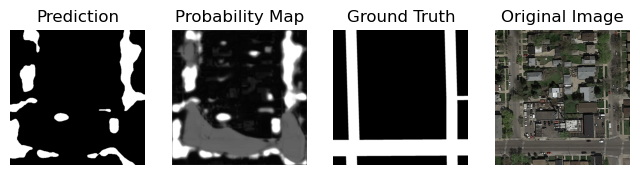

In [36]:
# get plot examples with the trained or loaded UNet model, and train or loaded RC parameters (still on train data)
n_examples = 10

dataset_check = Road_data(imgs, gt_imgs)
dataloader = DataLoader(dataset_check, batch_size=n_examples, shuffle=True)
threshold = 0.5
for batch_idx, (data, target) in enumerate(dataloader):

    gt = target
    pred = model(data)
    gt_np = gt.detach().cpu().numpy()
    pred_np = pred.detach().cpu().numpy()

    for i in range(n_examples):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 8))

        prediction, _, _, _ = process_roads(raw_map=pred_np[i], threshold=threshold, outlier_size=best_outlier_size, shape_size=best_shape_size)
        axes[0].imshow(prediction, cmap='gray')
        axes[0].set_title("Prediction")
        
        axes[1].imshow(pred_np[i], cmap='gray')
        axes[1].set_title("Probability Map")

        axes[2].imshow(gt_np[i], cmap='gray')
        axes[2].set_title("Ground Truth")

        img_np = data[i].permute(1, 2, 0).cpu().numpy() 

        axes[3].imshow(img_np)
        axes[3].set_title("Original Image")

        axes[0].axis("off")
        axes[1].axis("off")
        axes[2].axis("off")
        axes[3].axis("off")

        plt.show()
    
    break

In [37]:
# best_shape_size = 8
# best_outlier_size = 80
# best_threshold = 0.45 - 0.50
# Copy of output
'''
(2,2)
Epoch 10/10, Loss: 0.7271
(3,2)
Epoch 10/10, Loss: 0.7983
(4,2)
Epoch 6/10, Loss: 0.8487
Epoch 7/10, Loss: 0.8037
Epoch 8/10, Loss: 0.7896
Epoch 9/10, Loss: 0.8194
Epoch 10/10, Loss: 0.8030
(5,2)
Epoch 10/10, Loss: 0.7603
(6,2)
Epoch 7/10, Loss: 0.8367
Epoch 8/10, Loss: 0.8041
Epoch 9/10, Loss: 0.7919
Epoch 10/10, Loss: 0.8159
(2,4)
Epoch 10/10, Loss: 0.7353
(3,4)
Epoch 10/10, Loss: 0.7317
(4,4)
Epoch 7/10, Loss: 0.7212
Epoch 8/10, Loss: 0.7214
Epoch 9/10, Loss: 0.7083
Epoch 10/10, Loss: 0.7170
(5,4)
Epoch 7/10, Loss: 0.7716
Epoch 8/10, Loss: 0.7631
Epoch 9/10, Loss: 0.7285
Epoch 10/10, Loss: 0.7535
(6,4)
Epoch 7/10, Loss: 0.7280
Epoch 8/10, Loss: 0.7524
Epoch 9/10, Loss: 0.7306
Epoch 10/10, Loss: 0.6984
(2,8)
Epoch 10/10, Loss: 0.6975
(3,8)
Epoch 10/10, Loss: 0.7063
(4,8)
Epoch 10/10, Loss: 0.6899
(5,8)
Epoch 7/10, Loss: 0.7355
Epoch 8/10, Loss: 0.7171
Epoch 9/10, Loss: 0.6915
Epoch 10/10, Loss: 0.7085
(6,8)
Epoch 10/10, Loss: 0.6920
down
(2,16)
Epoch 8/10, Loss: 0.6867
Epoch 9/10, Loss: 0.6995
Epoch 10/10, Loss: 0.6900
(3,16)
Epoch 7/10, Loss: 0.6969
Epoch 8/10, Loss: 0.6711
Epoch 9/10, Loss: 0.6747
Epoch 10/10, Loss: 0.6778
(4,16)
Epoch 7/10, Loss: 0.6805
Epoch 8/10, Loss: 0.6782
Epoch 9/10, Loss: 0.6719
Epoch 10/10, Loss: 0.6583
(5,16)
Epoch 6/10, Loss: 0.7078
Epoch 7/10, Loss: 0.7302
Epoch 8/10, Loss: 0.6718
Epoch 9/10, Loss: 0.6683
Epoch 10/10, Loss: 0.6839
(6,16)
Epoch 6/10, Loss: 0.6901
Epoch 7/10, Loss: 0.6790
Epoch 8/10, Loss: 0.6811
Epoch 9/10, Loss: 0.6777
Epoch 10/10, Loss: 0.6808
(2,32)
Epoch 6/10, Loss: 0.6958
Epoch 7/10, Loss: 0.6868
Epoch 8/10, Loss: 0.7193
Epoch 9/10, Loss: 0.6966
Epoch 10/10, Loss: 0.6718
(3,32)
Epoch 6/10, Loss: 0.7020
Epoch 7/10, Loss: 0.6866
Epoch 8/10, Loss: 0.6826
Epoch 9/10, Loss: 0.6949
Epoch 10/10, Loss: 0.6761
(4,32)
Epoch 7/10, Loss: 0.6746
Epoch 8/10, Loss: 0.6920
Epoch 9/10, Loss: 0.6757
Epoch 10/10, Loss: 0.6643
(5,32)
Epoch 6/10, Loss: 0.7046
Epoch 7/10, Loss: 0.6784
Epoch 8/10, Loss: 0.6763
Epoch 9/10, Loss: 0.6922
Epoch 10/10, Loss: 0.6798
(6,32)
Epoch 1/10, Loss: 0.7677'''
# Crash at the end

'\n(2,2)\nEpoch 10/10, Loss: 0.7271\n(3,2)\nEpoch 10/10, Loss: 0.7983\n(4,2)\nEpoch 6/10, Loss: 0.8487\nEpoch 7/10, Loss: 0.8037\nEpoch 8/10, Loss: 0.7896\nEpoch 9/10, Loss: 0.8194\nEpoch 10/10, Loss: 0.8030\n(5,2)\nEpoch 10/10, Loss: 0.7603\n(6,2)\nEpoch 7/10, Loss: 0.8367\nEpoch 8/10, Loss: 0.8041\nEpoch 9/10, Loss: 0.7919\nEpoch 10/10, Loss: 0.8159\n(2,4)\nEpoch 10/10, Loss: 0.7353\n(3,4)\nEpoch 10/10, Loss: 0.7317\n(4,4)\nEpoch 7/10, Loss: 0.7212\nEpoch 8/10, Loss: 0.7214\nEpoch 9/10, Loss: 0.7083\nEpoch 10/10, Loss: 0.7170\n(5,4)\nEpoch 7/10, Loss: 0.7716\nEpoch 8/10, Loss: 0.7631\nEpoch 9/10, Loss: 0.7285\nEpoch 10/10, Loss: 0.7535\n(6,4)\nEpoch 7/10, Loss: 0.7280\nEpoch 8/10, Loss: 0.7524\nEpoch 9/10, Loss: 0.7306\nEpoch 10/10, Loss: 0.6984\n(2,8)\nEpoch 10/10, Loss: 0.6975\n(3,8)\nEpoch 10/10, Loss: 0.7063\n(4,8)\nEpoch 10/10, Loss: 0.6899\n(5,8)\nEpoch 7/10, Loss: 0.7355\nEpoch 8/10, Loss: 0.7171\nEpoch 9/10, Loss: 0.6915\nEpoch 10/10, Loss: 0.7085\n(6,8)\nEpoch 10/10, Loss: 0

In [38]:
import os
import re

# Define the root directory containing the test image folders
test_dir = "data/test_set_images/"

# Helper function to perform natural sorting
def natural_sort_key(s):
    # Extract numbers from the string for sorting
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# List all subdirectories (each containing one image) and sort them naturally
test_folders = sorted(
    [folder for folder in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, folder))],
    key=natural_sort_key
)

# Calculate the number of test images (based on the number of folders)
n_test = len(test_folders)
print("Loading " + str(n_test) + " images")

# Iterate over each folder, find the image, and load it
test_imgs = []
for folder in test_folders:
    folder_path = os.path.join(test_dir, folder)
    
    # List all files in the folder (assuming only one image per folder) and sort them naturally
    image_files = sorted(
        [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))],
        key=natural_sort_key
    )
    
    # Assuming there's only one image per folder, get the image file path
    if image_files:
        image_path = os.path.join(folder_path, image_files[0])
        test_imgs.append(load_image(image_path))

Loading 50 images


In [39]:
threshold = 0.5
test_imgs_np = np.array(test_imgs)
with torch.no_grad():
    images_test= torch.from_numpy(test_imgs_np).permute(0, 3, 1, 2)
    pred= model(images_test)
    pred_np = pred.detach().cpu().numpy()

In [42]:
from mask_to_submission import masks_to_submission
def getting_sub (prediction):

    output_dir = 'predictions_opti'
    os.makedirs(output_dir, exist_ok=True)

    # Save each prediction as an image
    pred_filenames = []
    for i in range(prediction.shape[0]):
        pred_mask = (prediction[i] > threshold).astype(np.uint8)  # Example thresholding, modify as needed
        pred_image = Image.fromarray(pred_mask * 255)  # Save the mask as a black and white image
        filename = os.path.join(output_dir, f"prediction_opti{i+1:03d}.png")
        pred_image.save(filename)
        pred_filenames.append(filename)

    # Now you can call the masks_to_submission function with the generated file paths
    submission_filename = 'UNet_opti.csv'
    masks_to_submission(submission_filename, *pred_filenames)
getting_sub(pred_np)